In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from time import process_time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import psutil

# def MAPE2(actual_values, predicted_values):
#     mape = np.mean(np.abs(np.where(np.logical_and(actual_values != 0, predicted_values != 0), (actual_values - predicted_values) / (actual_values + 1e-10), (actual_values - predicted_values) / 100)))
#     return mape

def MAPE(actual_values, predicted_values):
    mape_sum = 0.0
    count = 0

    for actual, predicted in zip(actual_values, predicted_values):
        if actual != 0 and predicted != 0:
            mape_sum += abs((actual - predicted) / actual)
        else:
            mape_sum += abs(actual - predicted) / 100
        count += 1

    if count == 0:
        return 0  # Handle the case when there are no valid entries to avoid division by zero.

    return (mape_sum / count)[0]

In [8]:
df1M = pd.DataFrame(np.loadtxt('./intersect.filter.csv', delimiter=','))
df1M.head() # show the first 5 rows

,0,1,2,3,4
0,-122.0,-37.0,-59.0,-24.0,49019.0
1,-166.0,-62.0,-139.0,-43.0,1040.0
2,99.0,30.0,115.0,68.0,66507.0
3,-159.0,-77.0,-112.0,-62.0,1041.0
4,-63.0,50.0,-3.0,66.0,68350.0


In [9]:
data = np.loadtxt('./intersect.filter.csv', delimiter=',')
Rectangles = data[:,0:4]
Rectangles.shape

(999999, 4)

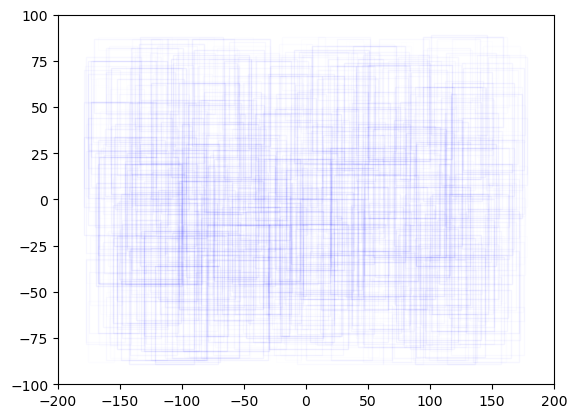

In [10]:
univ_xmin = -180
univ_xmax = 180
univ_ymin = -90
univ_ymax = 90
Surface_univ=(univ_xmax-univ_xmin)*(univ_ymax-univ_ymin)

s=0
rectanglesDensity = []
for i in Rectangles:
    s = abs((i[3]-i[1])*(i[2]-i[0])/Surface_univ)
    rectanglesDensity.append(s)
rectanglesDensity = np.array(rectanglesDensity)


# Plot 1000 rectangles from x1, y1 to x2, y2
ax = plt.subplot()
for rect, color in zip(Rectangles[0:1000], rectanglesDensity[0:1000]):
    x1, y1, x2, y2 = rect
    rectangle = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='b', facecolor='none', alpha=color)
    ax.add_patch(rectangle)
# The next code show the real rectangles forms with the color of the density
# plt.xlim(min(rect[0] for rect in Rectangles), max(rect[0] for rect in Rectangles))
# plt.ylim(min(rect[1] for rect in Rectangles), max(rect[1] for rect in Rectangles))
plt.xlim(-200, 200)
plt.ylim(-100, 100)
plt.show()

In [11]:
# Prepare data for the models the input is X and the output is Y
Y = data[:,4:5]
rectanglesDensity = rectanglesDensity.reshape(rectanglesDensity.shape[0],1)
X = np.append(data[:,0:4], rectanglesDensity, axis=1)
# X = data[:,0:4]

# Split the data into 80% train and 20% test
X_train, X_test_all, y_train, y_test_all = train_test_split(X, Y, test_size=0.2, random_state=3)


# Taking just 800K first data
sample_size = 800000
X_train = X_train[:sample_size,:]
y_train = y_train[:sample_size]
# X_sample = X_sample[:sample_size,:]
# Y_sample = Y_sample[:sample_size]

Y.shape # (999999, 1)
X.shape # (999999, 5)


columns = ['x_min','y_min','x_max','y_max','Density']
# columns = ['x_min','y_min','x_max','y_max']
Data_Set = pd.DataFrame(data=X,columns=columns)
column = ['number_of_objets']
Target = pd.DataFrame(data=Y,columns=column)

# Split the data into 80% train and 20% test
# X_train, X_test, y_train, y_test = train_test_split(X_sample, Y_sample, test_size=0.2, random_state=3)

# Max, min, mean and median
print("Max :", np.max(Y))
print("Min :", np.min(Y))
print("Mean :", np.mean(Y))
print("Median :", np.median(Y))


Max : 1683002.0
Min : 2.0
Mean : 172835.6677046677
Median : 65194.0


In [12]:
# XGBoost Regressor
print("###### XGBoost Regressor ######")
import xgboost
from sklearn.model_selection import GridSearchCV

# GridSearchCV
params_xgb = {"learning_rate": [0.01, 0.1, 0.3],
                "max_depth": [3, 4, 5, 6, 7, 8],
                "n_estimators": [100, 200, 300]}
xgb = xgboost.XGBRegressor(random_state=3)
xgb_cv = GridSearchCV(xgb, params_xgb, cv=5)

# Best hyperparameters
t1_start = process_time()
xgb_cv.fit(X_train, y_train)
t1_stop = process_time()
print("Elapsed time during the GridSearchCV (XGBoost):", t1_stop-t1_start, "s")
print("Tuned XGBoost Parameters: {}".format(xgb_cv.best_params_))
print("Best score is {}".format(xgb_cv.best_score_))

xgb = xgboost.XGBRegressor(**xgb_cv.best_params_, random_state=3)

# Instantiate xgb
# Fit xgb to the training set
t1_start = process_time()
xgb.fit(X_train, y_train)
t1_stop = process_time()
print("Elapsed time during the learning phase in seconds (XGBoost):", t1_stop-t1_start, "s")
# Predict test set labels
y_pred = xgb.predict(X_test_all)
# Compute and print R^2 and RMSE
print("R^2: {}".format(xgb.score(X_test_all, y_test_all)))
# print("Mean Absolute Error: {}".format(MAE(y_test, y_pred)))
# print(f"Mean Absolute Percentage Error: {MAPE(y_test, y_pred):.2%}")
print(f"Mean Absolute Error of 20% of all: {MAE(y_test_all, xgb.predict(X_test_all)):.2f}")
print(f"Mean Absolute Percentage Error of 20% of all: {MAPE(y_test_all, xgb.predict(X_test_all)):.2%}")
# Save the model named with sample_size and the MAPE value and MAE value
import pickle
filename = f'./LearnedModels/XGB/xgb_withCoverageRatio_{sample_size}_{(t1_stop-t1_start):.2f}s_{MAPE(y_test_all, xgb.predict(X_test_all)):.2%}_{MAE(y_test_all, xgb.predict(X_test_all)):.2f}.sav'
pickle.dump(xgb, open(filename, 'wb'))

# Time to predict calculated 10 times and the average is calculated
total_duration = 0
total_read = 0
total_write = 0
for i in range(10):
    io_before = psutil.disk_io_counters()
    t1_start = process_time()
    y_pred_tmp = xgb.predict(X_test_all)
    t1_stop = process_time()
    io_after = psutil.disk_io_counters()
    total_duration += (t1_stop-t1_start)
    total_read += io_after.read_count - io_before.read_count
    total_write += io_after.write_count - io_before.write_count

print(f"I/O Operations (mean of 10 times) - Reads: {total_read/10/len(y_pred_tmp)}, Writes: {total_write/10/len(y_pred_tmp)}")
print("Elapsed time during one estimation in seconds (mean of 10 times):", (total_duration/10)/len(y_pred_tmp))
print("Elapsed time during one estimation in microseconds (mean of 10 times):", (total_duration/10)/len(y_pred_tmp)*1000000)



###### XGBoost Regressor ######
Elapsed time during the GridSearchCV (XGBoost): 300.23731093799995 s
Tuned XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Best score is 0.997708326278187
Elapsed time during the learning phase in seconds (XGBoost): 57.275354109000034 s
R^2: 0.9976895316323556
Mean Absolute Error of 20% of all: 7452.30
Mean Absolute Percentage Error of 20% of all: 29.69%
I/O Operations (mean of 10 times) - Reads: 0.0, Writes: 2.2000000000000003e-05
Elapsed time during one estimation in seconds (mean of 10 times): 1.4415621279500102e-05
Elapsed time during one estimation in microseconds (mean of 10 times): 14.415621279500103


In [13]:
# Calculate the q-score (max(y_pred/y_true, y_true/y_pred))
q_score = []
for i in range(len(y_test_all)):
    q_score.append(max(y_pred[i]/y_test_all[i], y_test_all[i]/y_pred[i]))
q_score = np.array(q_score)
print(f"q-score: {np.mean(q_score):.2f}")
# q-score of all
q_score_all = []
mlpPredicted = xgb.predict(X_test_all)
for i in range(len(y_test_all)):
    if mlpPredicted[i] != 0 and y_test_all[i] != 0:
        q_score_all.append(max(mlpPredicted[i]/y_test_all[i], y_test_all[i]/mlpPredicted[i]))
q_score_all = np.array(q_score_all)
print(f"q-score of 20% of all: {np.mean(q_score_all):.2f}")

q-score: 1.31
q-score of 20% of all: 1.31


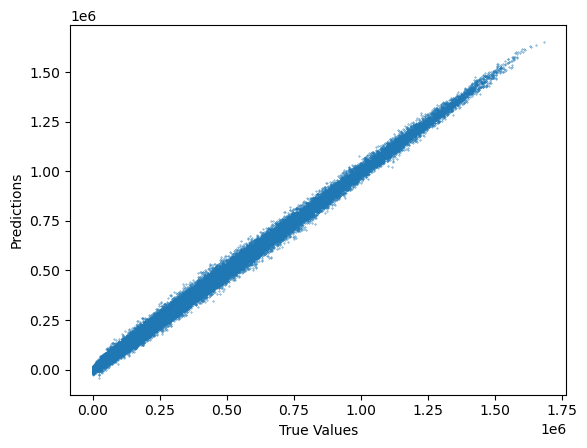

In [14]:
# Plot the predicted values against the true values
plt.scatter(y_test_all, y_pred, s=0.1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()